# Cait with Mixup

In [1]:
!pip install python-box timm pytorch-lightning ttach torchmetrics torchtoolbox albumentations wandb -q

You should consider upgrading via the '/usr/bin/python3.9 -m pip install --upgrade pip' command.


In [2]:
!rm -r cait_m36_384

rm: cannot remove 'cait_m36_384': No such file or directory


In [3]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [4]:
import os
import warnings
from pprint import pprint
from glob import glob
from tqdm import tqdm
import torchmetrics

import numpy

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms as T
from box import Box
from timm import create_model
from sklearn.model_selection import StratifiedKFold
from torchvision.io import read_image
from torch.utils.data import DataLoader, Dataset
from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image


import pytorch_lightning as pl
from pytorch_lightning.utilities.seed import seed_everything
from pytorch_lightning import callbacks
from pytorch_lightning.callbacks.progress import ProgressBarBase
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import LightningDataModule, LightningModule


warnings.filterwarnings("ignore")

In [5]:
print(torch.__version__)

1.10.0+cu113


In [6]:
# import timm
# timm.list_models(pretrained=True)

## config

In [7]:
# !rm ./convit_base -r

In [8]:
config = {'seed': 42,
          'root': '/hy-tmp', 
          'n_splits': 5,
          'epoch': 30,
          'trainer': {
              'gpus': 1,
              'accumulate_grad_batches': 1,
              'progress_bar_refresh_rate': 0,
              'fast_dev_run': False,
              'num_sanity_val_steps': 0,
              'resume_from_checkpoint': None,
          },
          'transform':{
              'name': 'get_default_transforms',
              'image_size': 224
          },
          'train_loader':{
              'batch_size': 32,
              'shuffle': True,
              'num_workers': 4,
              'pin_memory': False,
              'drop_last': True,
          },
          'val_loader': {
              'batch_size': 8,
              'shuffle': False,
              'num_workers': 4,
              'pin_memory': False,
              'drop_last': False
         },
          'model':{
              'name': 'convit_base',
              'output_dim': 6
          },
          'optimizer':{
              'name': 'optim.AdamW',
              'params':{
                  'lr': 1e-5
              },
          },
          'scheduler':{
              'name': 'optim.lr_scheduler.CosineAnnealingWarmRestarts',
              'params':{
                  'T_0': 20,
                  'eta_min': 3e-6,
              }
          },
          'loss': 'nn.CrossEntropyLoss',
}

config = Box(config)

In [9]:
pprint(config)

{'epoch': 30,
 'loss': 'nn.CrossEntropyLoss',
 'model': Box({'name': 'convit_base', 'output_dim': 6}),
 'n_splits': 5,
 'optimizer': Box({'name': 'optim.AdamW', 'params': {'lr': 1e-05}}),
 'root': '/hy-tmp',
 'scheduler': {'name': 'optim.lr_scheduler.CosineAnnealingWarmRestarts',
               'params': Box({'T_0': 20, 'eta_min': 3e-06})},
 'seed': 42,
 'train_loader': {'batch_size': 32,
                  'drop_last': True,
                  'num_workers': 4,
                  'pin_memory': False,
                  'shuffle': True},
 'trainer': {'accumulate_grad_batches': 1,
             'fast_dev_run': False,
             'gpus': 1,
             'num_sanity_val_steps': 0,
             'progress_bar_refresh_rate': 0,
             'resume_from_checkpoint': None},
 'transform': Box({'name': 'get_default_transforms', 'image_size': 224}),
 'val_loader': {'batch_size': 8,
                'drop_last': False,
                'num_workers': 4,
                'pin_memory': False,
            

## dataset

In [10]:
class EMSIGDataset(Dataset):
    def __init__(self, df, image_size=384, transform=None):
        self._X = df["id"].values
        self._y = None
        if "target" in df.keys():
            self._y = df["target"].values
#         self._transform = T.Resize([image_size, image_size])
        self._transform = transform

    def __len__(self):
        return len(self._X)

    def __getitem__(self, idx):
        image_path = self._X[idx]
#         image = read_image(image_path)
#         image = self._transform(image)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        augmented = self._transform(image=image)
#         print('augment')
        image = augmented['image']
#         print('augmented ')
        if self._y is not None:
            label = self._y[idx]
            return image, label
        return image

class EMSIGDataModule(LightningDataModule):
    def __init__(
        self,
        train_df,
        val_df,
        cfg,
    ):
        super().__init__()
        self._train_df = train_df
        self._val_df = val_df
        self._cfg = cfg

    def __create_dataset(self, train=True):
        return (
            EMSIGDataset(self._train_df, self._cfg.transform.image_size, transform = get_default_transforms()['train'])
            if train
            else EMSIGDataset(self._val_df, self._cfg.transform.image_size, transform = get_default_transforms()['val'])
        )

    def train_dataloader(self):
        dataset = self.__create_dataset(True)
        return DataLoader(dataset, **self._cfg.train_loader)

    def val_dataloader(self):
        dataset = self.__create_dataset(False)
        return DataLoader(dataset, **self._cfg.val_loader)

## visualize data

In [11]:
torch.autograd.set_detect_anomaly(True)
seed_everything(config.seed)

df = pd.read_csv('/hy-tmp/train_labels.csv')
df["id"] = df["id"].apply(lambda x: os.path.join(config.root, "crop_spectrum_train_pic", x))

Global seed set to 42


In [12]:
df['target'] = df['target'] - 1

## augmentation

In [13]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]  # RGB
IMAGENET_STD = [0.229, 0.384, 0.225]  # RGB
IMAGE_SIZE = config.transform.image_size

def get_default_transforms():
    transform = {
        "train": A.Compose(
            [
                A.Resize(IMAGE_SIZE, IMAGE_SIZE),
#                 A.Cutout(num_holes=1, max_h_size=IMAGE_SIZE, max_w_size=int(IMAGE_SIZE/8)),
#                 A.Cutout(num_holes=1, max_h_size=int(IMAGE_SIZE/8), max_w_size=IMAGE_SIZE),
                A.CoarseDropout(max_holes=2, max_height=IMAGE_SIZE, max_width=int(IMAGE_SIZE/8), min_holes=1, min_height=None, min_width=int(IMAGE_SIZE/16), fill_value=[0, 0, 225]),
                A.CoarseDropout(max_holes=2, max_height=int(IMAGE_SIZE/8), max_width=IMAGE_SIZE, min_holes=1, min_height=int(IMAGE_SIZE/16), min_width=None, fill_value=[0, 0, 225]),
                A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
                ToTensorV2(),
            ]
        ),
        "val": A.Compose(
            [
                A.Resize(IMAGE_SIZE, IMAGE_SIZE),
                A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
                ToTensorV2()
            ]
        ),
    }
    return transform


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

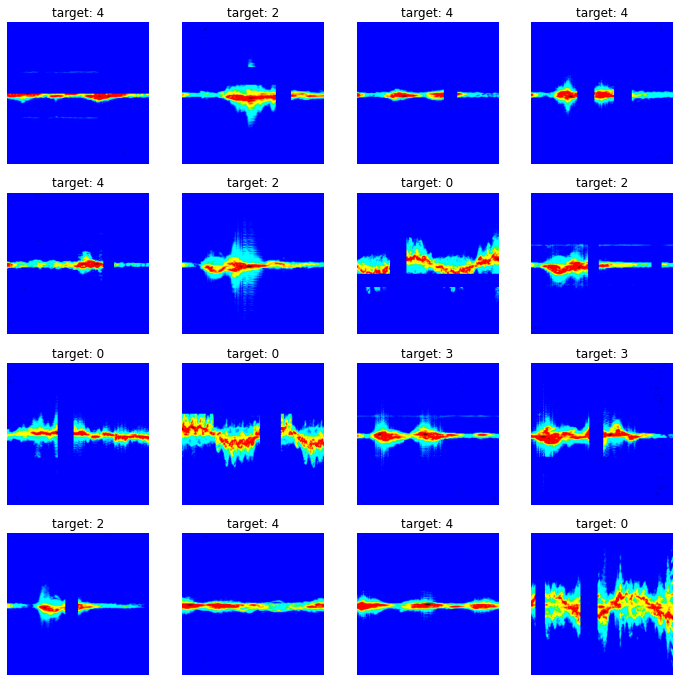

In [14]:
sample_dataloader = EMSIGDataModule(df, df, config).train_dataloader()
images, labels = iter(sample_dataloader).next()

plt.figure(figsize=(12, 12))
for it, (image, label) in enumerate(zip(images[:16], labels[:16])):
    plt.subplot(4, 4, it+1)
    plt.imshow(image.permute(1, 2, 0))
    plt.axis('off')
    plt.title(f'target: {int(label)}')

## model

In [15]:
def mixup(x: torch.Tensor, y: torch.Tensor, alpha: float = 1.0):
    assert alpha > 0, "alpha should be larger than 0"
    assert x.size(0) > 1, "Mixup cannot be applied to a single instance."

    lam = np.random.beta(alpha, alpha)
    rand_index = torch.randperm(x.size()[0])
    mixed_x = lam * x + (1 - lam) * x[rand_index, :]
    target_a, target_b = y, y[rand_index]
    return mixed_x, target_a, target_b, lam

In [16]:
fuc = get_default_transforms()['train']

In [17]:
class Model(pl.LightningModule):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.__build_model()
        self._criterion = eval(self.cfg.loss)()
        self.transform = get_default_transforms()
        self.save_hyperparameters(cfg)

    def __build_model(self):
        self.backbone = create_model(
            self.cfg.model.name, pretrained=True, num_classes=0, in_chans=3
        )
        self.fc = nn.Sequential(
            nn.Dropout(0.5), 
            nn.Linear(self.backbone.num_features, 64),
            nn.Dropout(0.5), 
            nn.Linear(64, self.cfg.model.output_dim)
        )
        

    def forward(self, x):
        f = self.backbone(x)
        out = self.fc(f)
        return out

    def training_step(self, batch, batch_idx):
        loss, pred, labels = self.__share_step(batch, 'train')
        # print('train loss: ', loss)
        return {'loss': loss, 'pred': pred, 'labels': labels}
        
    def validation_step(self, batch, batch_idx):
        loss, pred, labels = self.__share_step(batch, 'val')
        # print('valid loss: ', loss)
        return {'pred': pred, 'labels': labels}
    
    def __share_step(self, batch, mode):
        images, labels = batch
    
    # mixup
        # if torch.rand(1)[0] < 0.5 and mode == 'train':
        #     mix_images, target_a, target_b, lam = mixup(images, labels, alpha=0.5)
        #     pred = self.forward(mix_images)
        #     loss = self._criterion(pred, target_a) * lam + \
        #         (1 - lam) * self._criterion(pred, target_b)
        # else:
        #     pred = self.forward(images)
        #     loss = self._criterion(pred, labels)
        
        pred = self.forward(images)
        loss = self._criterion(pred, labels)
        
        pred_cpu = pred.detach().cpu()# * 100.
        labels = labels.detach().cpu()# * 100.
        return loss, pred_cpu, labels
        
    def training_epoch_end(self, outputs):
        print('-----train-----')
        self.__share_epoch_end(outputs, 'train')

    def validation_epoch_end(self, outputs):
        print('-----valid-----')
        self.__share_epoch_end(outputs, 'val')    
        
    def __share_epoch_end(self, outputs, mode):
        preds = []
        labels = []
        for out in outputs:
            pred, label = out['pred'], out['labels']
            preds.append(pred)
            labels.append(label)
        preds = torch.cat(preds)
        labels = torch.cat(labels)
        loss = self._criterion(preds, labels)
        metrics = torchmetrics.functional.accuracy(preds, labels, average='macro', num_classes=6)
        sfmx = nn.Softmax(dim = 1)
        preds_prob = sfmx(preds)
        cm = torchmetrics.functional.confusion_matrix(preds_prob, labels, num_classes=6, normalize=None, threshold=0.5, multilabel=False)
        print(cm.numpy().tolist())
        print('Accuracy： ', float(metrics.numpy()))
        print('Epoch loss: ', float(loss.numpy()))
        self.log(f'Fold_{FOLD}_{mode}_loss', float(loss.numpy()))
        self.log(f'{mode}_loss', float(loss.numpy()))
        self.log(f'Fold_{FOLD}_{mode}_acc', float(metrics.numpy()))
    

    def configure_optimizers(self):
        optimizer = eval(self.cfg.optimizer.name)(
            self.parameters(), **self.cfg.optimizer.params
        )
        scheduler = eval(self.cfg.scheduler.name)(
            optimizer,
            **self.cfg.scheduler.params
        )
        return [optimizer], [scheduler]

## train

In [18]:
%%time

skf = StratifiedKFold(
    n_splits=config.n_splits, shuffle=True, random_state=config.seed
)

FOLD = 0

for fold, (train_idx, val_idx) in enumerate(skf.split(df["id"], df["target"])):
    print('FOLD: ', FOLD)
    train_df = df.loc[train_idx].reset_index(drop=True)
    val_df = df.loc[val_idx].reset_index(drop=True)
#     train_name = 'train' + str(FOLD) + '.csv'
#     valid_name = 'valid' + str(FOLD) + '.csv'
#     train_df.to_csv(train_name)
#     val_df.to_csv(valid_name)
    datamodule = EMSIGDataModule(train_df, val_df, config)
    model = Model(config)
    earystopping = EarlyStopping(monitor="val_loss", mode="min", patience=5)
    lr_monitor = callbacks.LearningRateMonitor()
    loss_checkpoint = callbacks.ModelCheckpoint(
        filename="best_loss",
        monitor="val_loss",
        save_top_k=1,
        mode="min",
        save_last=False,
    )
    logger = WandbLogger(project='convit-no-mixup',
                         log_model=False)
    
    trainer = pl.Trainer(
        logger=logger,
        max_epochs=config.epoch,
        callbacks= earystopping,
        **config.trainer,
    )
    trainer.fit(model, datamodule=datamodule)
    # PATH = './' + str(fold)
    # torch.save(model.state_dict(), PATH)
    FOLD += 1

FOLD:  0


wandb: Currently logged in as: bingliangli (use `wandb login --relogin` to force relogin)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params
------------------------------------------------
0 | backbone   | ConViT           | 85.8 M
1 | fc         | Sequential       | 49.6 K
2 | _criterion | CrossEntropyLoss | 0     
------------------------------------------------
85.8 M    Trainable params
0         Non-trainable params
85.8 M    Total params
343.283   Total estimated model params size (MB)


-----valid-----
[[62, 0, 0, 0, 1, 0], [0, 57, 0, 0, 5, 0], [3, 38, 18, 0, 4, 0], [2, 37, 0, 9, 13, 0], [1, 16, 2, 1, 42, 0], [1, 2, 2, 0, 1, 34]]
Accuracy：  0.6440261602401733
Epoch loss:  1.2637609243392944
-----train-----
[[122, 21, 49, 27, 13, 10], [9, 101, 65, 24, 39, 7], [9, 64, 81, 30, 48, 12], [14, 69, 67, 38, 46, 11], [16, 69, 64, 25, 67, 6], [12, 33, 42, 11, 11, 44]]
Accuracy：  0.3270471692085266
Epoch loss:  1.6257705688476562
-----valid-----
[[62, 0, 0, 0, 1, 0], [0, 54, 1, 0, 7, 0], [1, 1, 59, 0, 2, 0], [1, 8, 2, 41, 9, 0], [1, 2, 3, 8, 48, 0], [1, 0, 2, 0, 1, 36]]
Accuracy：  0.8563212752342224
Epoch loss:  0.7815525531768799
-----train-----
[[236, 3, 3, 1, 2, 1], [2, 158, 23, 26, 30, 8], [8, 42, 121, 27, 40, 5], [6, 54, 30, 80, 71, 0], [5, 42, 38, 31, 125, 4], [1, 12, 15, 7, 6, 113]]
Accuracy：  0.612148106098175
Epoch loss:  1.1463398933410645
-----valid-----
[[62, 0, 0, 0, 1, 0], [0, 59, 0, 0, 3, 0], [0, 1, 59, 2, 1, 0], [0, 5, 1, 48, 7, 0], [0, 2, 1, 11, 47, 1], [0, 0, 0

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params
------------------------------------------------
0 | backbone   | ConViT           | 85.8 M
1 | fc         | Sequential       | 49.6 K
2 | _criterion | CrossEntropyLoss | 0     
------------------------------------------------
85.8 M    Trainable params
0         Non-trainable params
85.8 M    Total params
343.283   Total estimated model params size (MB)


-----valid-----
[[63, 0, 0, 0, 0, 0], [0, 44, 6, 3, 10, 0], [2, 4, 39, 4, 13, 0], [0, 9, 7, 25, 21, 0], [0, 1, 6, 11, 44, 0], [0, 9, 0, 1, 0, 29]]
Accuracy：  0.6973230242729187
Epoch loss:  1.3608461618423462
-----train-----
[[141, 18, 20, 40, 16, 7], [14, 68, 25, 100, 36, 4], [22, 55, 36, 101, 27, 2], [20, 36, 35, 125, 25, 3], [21, 34, 32, 116, 39, 2], [14, 32, 32, 62, 12, 4]]
Accuracy：  0.28397810459136963
Epoch loss:  1.7012486457824707
-----valid-----
[[63, 0, 0, 0, 0, 0], [0, 57, 1, 2, 3, 0], [0, 0, 58, 2, 2, 0], [0, 1, 3, 43, 15, 0], [0, 1, 4, 9, 48, 0], [0, 0, 0, 0, 0, 39]]
Accuracy：  0.8846646547317505
Epoch loss:  0.8975363969802856
-----train-----
[[238, 3, 0, 3, 2, 2], [3, 117, 41, 45, 36, 1], [5, 30, 114, 59, 36, 1], [2, 34, 46, 102, 53, 3], [0, 36, 34, 69, 103, 2], [3, 18, 31, 21, 14, 69]]
Accuracy：  0.5326506495475769
Epoch loss:  1.276938796043396
-----valid-----
[[63, 0, 0, 0, 0, 0], [0, 61, 0, 0, 2, 0], [0, 1, 58, 1, 2, 0], [0, 0, 3, 41, 18, 0], [0, 1, 0, 8, 53, 0], [0

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params
------------------------------------------------
0 | backbone   | ConViT           | 85.8 M
1 | fc         | Sequential       | 49.6 K
2 | _criterion | CrossEntropyLoss | 0     
------------------------------------------------
85.8 M    Trainable params
0         Non-trainable params
85.8 M    Total params
343.283   Total estimated model params size (MB)


-----valid-----
[[58, 3, 1, 0, 0, 0], [0, 50, 0, 7, 6, 0], [0, 0, 48, 5, 9, 0], [0, 2, 10, 29, 21, 0], [0, 1, 2, 12, 47, 0], [0, 0, 4, 10, 0, 25]]
Accuracy：  0.7283599972724915
Epoch loss:  1.334078311920166
-----train-----
[[69, 56, 32, 30, 23, 35], [8, 82, 45, 41, 43, 26], [8, 46, 67, 35, 76, 16], [8, 46, 38, 48, 76, 24], [7, 45, 42, 44, 92, 13], [4, 27, 39, 36, 20, 29]]
Accuracy：  0.2753642499446869
Epoch loss:  1.7066468000411987
-----valid-----
[[61, 1, 0, 0, 0, 0], [0, 58, 1, 0, 4, 0], [0, 0, 56, 1, 5, 0], [0, 1, 7, 38, 16, 0], [0, 0, 3, 9, 50, 0], [0, 0, 3, 0, 0, 36]]
Accuracy：  0.8583606481552124
Epoch loss:  0.7482574582099915
-----train-----
[[226, 12, 1, 4, 4, 0], [3, 197, 5, 14, 16, 8], [2, 27, 119, 32, 55, 10], [3, 38, 36, 96, 63, 7], [0, 32, 37, 32, 137, 5], [4, 11, 26, 14, 6, 94]]
Accuracy：  0.6294488906860352
Epoch loss:  1.1746885776519775
-----valid-----
[[62, 0, 0, 0, 0, 0], [0, 59, 0, 2, 2, 0], [0, 0, 54, 3, 5, 0], [0, 0, 0, 51, 11, 0], [0, 0, 0, 19, 43, 0], [0, 0, 

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params
------------------------------------------------
0 | backbone   | ConViT           | 85.8 M
1 | fc         | Sequential       | 49.6 K
2 | _criterion | CrossEntropyLoss | 0     
------------------------------------------------
85.8 M    Trainable params
0         Non-trainable params
85.8 M    Total params
343.283   Total estimated model params size (MB)


-----valid-----
[[59, 1, 0, 1, 1, 0], [0, 24, 0, 30, 8, 0], [0, 4, 23, 27, 8, 0], [0, 0, 1, 49, 12, 0], [0, 0, 0, 26, 36, 0], [0, 4, 12, 6, 0, 18]]
Accuracy：  0.5884408354759216
Epoch loss:  1.36922287940979
-----train-----
[[61, 55, 53, 24, 14, 38], [11, 74, 66, 31, 44, 18], [12, 49, 82, 35, 47, 22], [20, 43, 59, 52, 56, 11], [7, 32, 68, 44, 84, 10], [4, 35, 50, 18, 20, 27]]
Accuracy：  0.2696985900402069
Epoch loss:  1.7116732597351074
-----valid-----
[[61, 1, 0, 0, 0, 0], [0, 60, 0, 1, 1, 0], [0, 0, 56, 2, 4, 0], [0, 4, 6, 31, 21, 0], [0, 2, 2, 10, 47, 1], [0, 0, 1, 0, 0, 39]]
Accuracy：  0.8479838967323303
Epoch loss:  0.7452943921089172
-----train-----
[[219, 8, 8, 5, 2, 1], [5, 139, 15, 60, 18, 11], [4, 41, 131, 29, 34, 7], [4, 37, 22, 112, 61, 7], [0, 25, 13, 63, 133, 5], [2, 23, 35, 5, 7, 85]]
Accuracy：  0.5921717882156372
Epoch loss:  1.2012708187103271
-----valid-----
[[60, 2, 0, 0, 0, 0], [0, 59, 0, 1, 2, 0], [0, 0, 53, 5, 4, 0], [0, 1, 2, 46, 13, 0], [0, 0, 0, 15, 47, 0], [0,

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params
------------------------------------------------
0 | backbone   | ConViT           | 85.8 M
1 | fc         | Sequential       | 49.6 K
2 | _criterion | CrossEntropyLoss | 0     
------------------------------------------------
85.8 M    Trainable params
0         Non-trainable params
85.8 M    Total params
343.283   Total estimated model params size (MB)


-----valid-----
[[58, 0, 4, 0, 0, 0], [0, 16, 41, 2, 2, 1], [1, 2, 59, 0, 0, 0], [1, 4, 47, 4, 6, 0], [0, 0, 35, 0, 27, 0], [0, 0, 5, 1, 0, 34]]
Accuracy：  0.5825268626213074
Epoch loss:  1.4284974336624146
-----train-----
[[67, 31, 19, 65, 58, 3], [9, 40, 38, 99, 54, 8], [13, 40, 53, 77, 55, 8], [10, 43, 42, 91, 46, 10], [7, 34, 45, 75, 69, 10], [10, 18, 20, 46, 36, 27]]
Accuracy：  0.24799421429634094
Epoch loss:  1.709220051765442
-----valid-----
[[62, 0, 0, 0, 0, 0], [0, 52, 1, 1, 7, 1], [1, 1, 47, 0, 11, 2], [0, 5, 4, 27, 25, 1], [0, 1, 1, 4, 56, 0], [0, 1, 0, 0, 1, 38]]
Accuracy：  0.8142473101615906
Epoch loss:  0.8902759552001953
-----train-----
[[229, 3, 7, 4, 3, 0], [7, 104, 44, 49, 36, 7], [5, 63, 94, 21, 58, 4], [14, 58, 47, 75, 44, 2], [3, 27, 51, 29, 130, 3], [3, 11, 5, 13, 7, 116]]
Accuracy：  0.5552477836608887
Epoch loss:  1.276694416999817
-----valid-----
[[62, 0, 0, 0, 0, 0], [0, 61, 0, 1, 0, 0], [1, 0, 57, 3, 1, 0], [0, 3, 1, 45, 13, 0], [0, 2, 1, 13, 46, 0], [0, 1, 0,

# Model info

In [19]:
print(model)

Model(
  (backbone): ConViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): GPSA(
          (qk): Linear(in_features=768, out_features=1536, bias=False)
          (v): Linear(in_features=768, out_features=768, bias=False)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (pos_proj): Linear(in_features=3, out_features=16, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU()
          (drop1): Dropout(p=0.0, inplace